In [1]:
import sys
sys.path.append('..')
import config as conf
import functions.notebook_helper_functions.notebook14 as funcs

paths = conf.DataFilePaths()
params = conf.ARIMA_model_parameters()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from scipy import stats
# from statistics import NormalDist

<a name="block_size"></a>
### 1. Experiment 1: block size by lag order and difference degree

In [2]:
sample_smape_scores_df = funcs.parse_results(
    input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}-block_size.parquet' 
)

sample_smape_scores_df.head(3)

,sample,model_type,block_size,lag_order,difference_degree,moving_average_order,SMAPE_score,log_SMAPE_score
0,0,ARIMA,9,0,0,0,3.186607,1.158957
1,0,ARIMA,9,0,1,0,0.998434,-0.001568
2,0,ARIMA,9,0,2,0,2.087234,0.735840



Winning control mean of sample SMAPE scores: 1.283261992926774
Winning control single sample SMAPE score: 0.5761180130215229

lag_order: [0, 1, 2]
difference_degree: [0, 1, 2]
moving_average_order: [0]
block_size: [9, 18, 37]



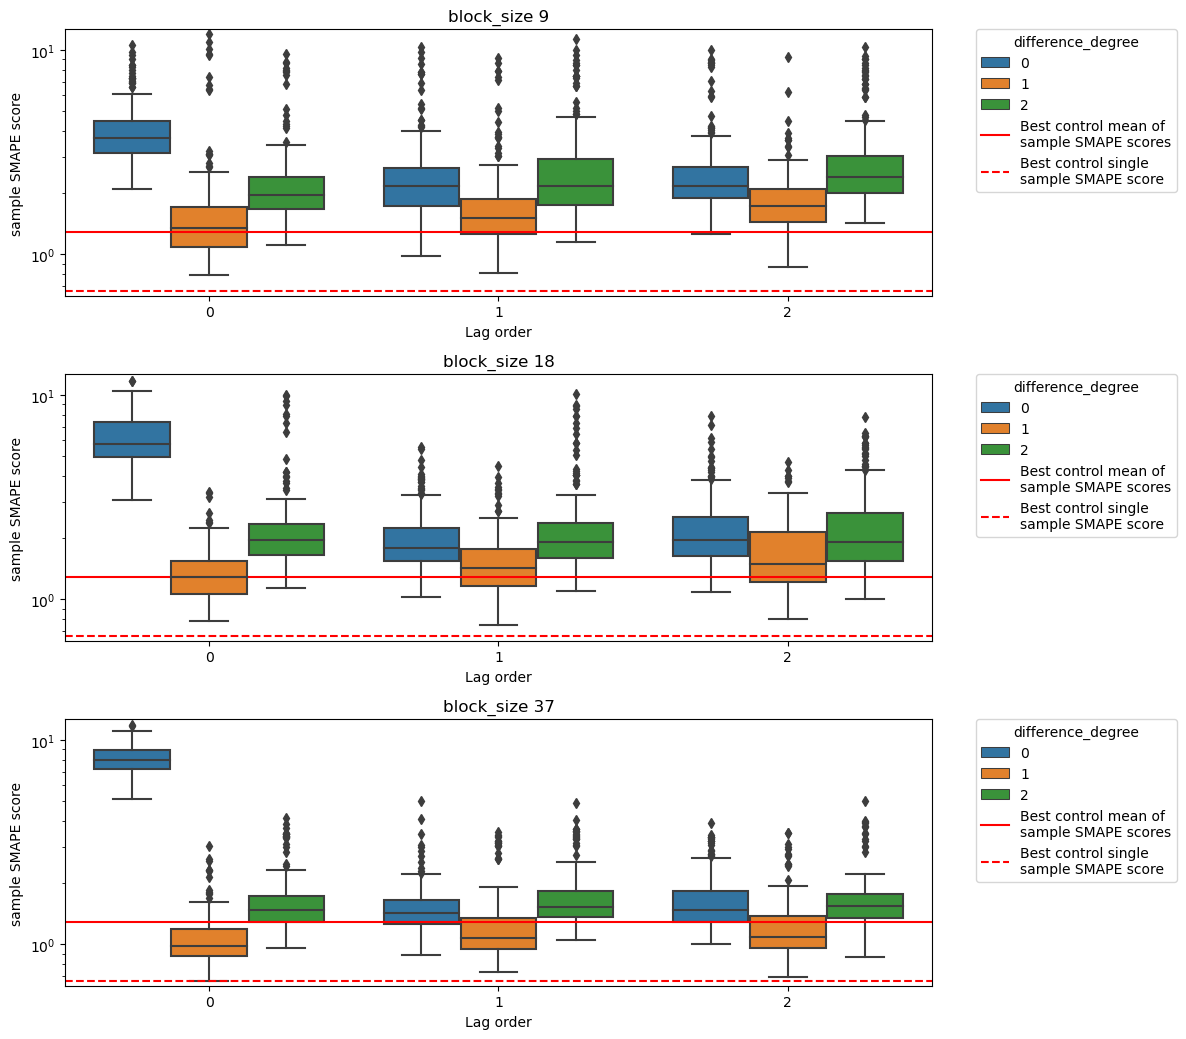

In [3]:

plt = funcs.sample_mean_smape_boxplot(
    sample_smape_scores_df,
    parameter = 'block_size',
    hue_by = 'difference_degree'
)

<a name="moving_average"></a>
### 2. Experiment 2: Moving average order by lag order and difference degree

In [4]:
sample_smape_scores_df = funcs.parse_results(
    input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}-moving_average_order.parquet'
)

sample_smape_scores_df.head(3)

,sample,model_type,block_size,lag_order,difference_degree,moving_average_order,SMAPE_score,log_SMAPE_score
0,0,ARIMA,37,0,0,0,7.935237,2.071313
1,0,ARIMA,37,0,0,1,4.869520,1.582995
2,0,ARIMA,37,0,0,2,3.672495,1.300871



Winning control mean of sample SMAPE scores: 1.085717400437214
Winning control single sample SMAPE score: 0.8589983753012376

lag_order: [0, 1, 2]
difference_degree: [0, 1, 2]
moving_average_order: [0, 1, 2]
block_size: [37]



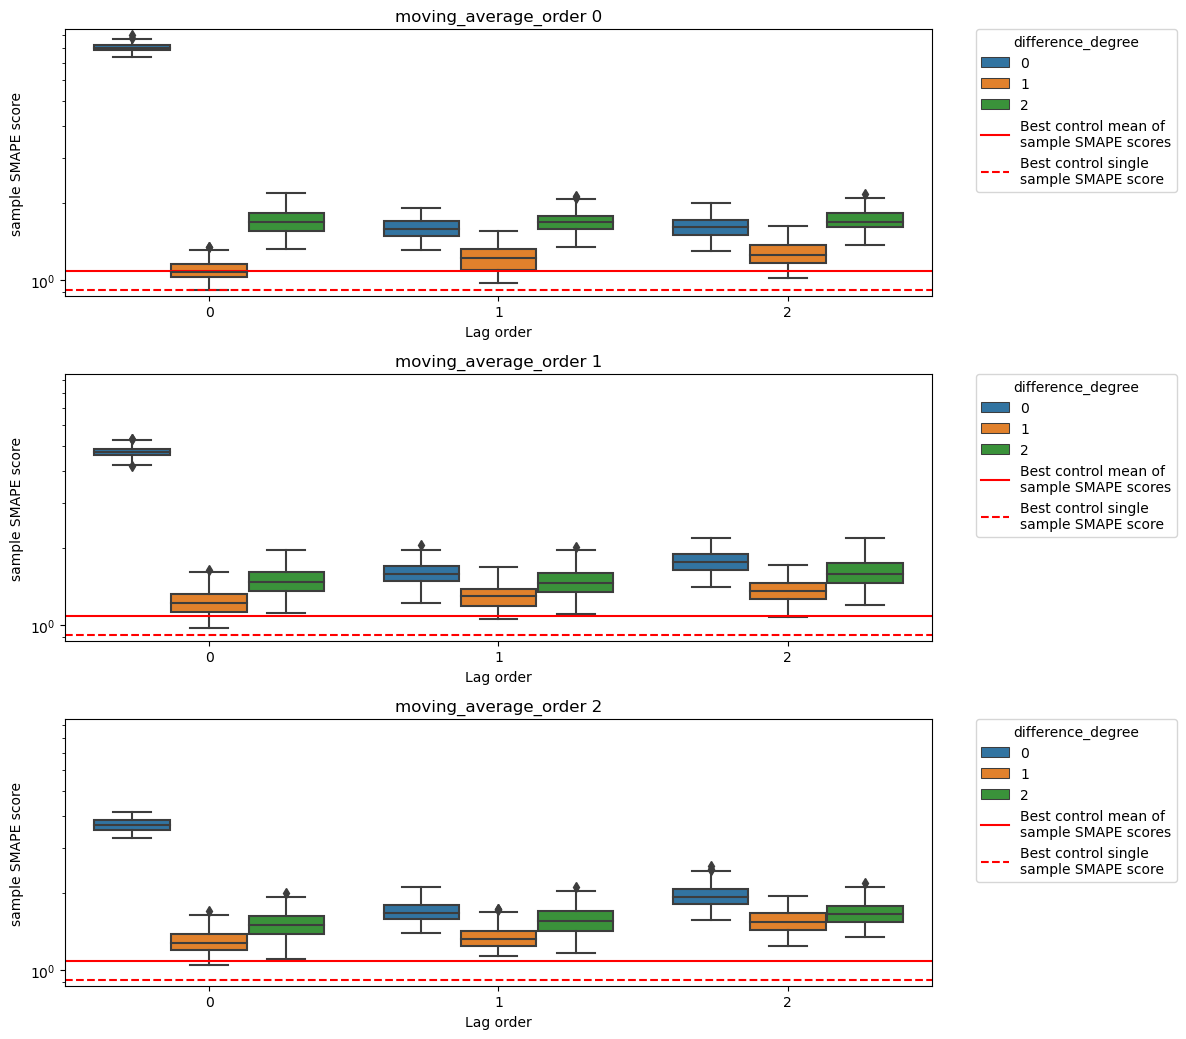

In [5]:
plt = funcs.sample_mean_smape_boxplot(
    sample_smape_scores_df,
    parameter = 'moving_average_order',
    hue_by = 'difference_degree'
)

<a name="winner"></a>
### 3. Experiment 3: Winning parameters, large sample

In [8]:
sample_smape_scores_df = funcs.parse_results(
    input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}-winning_parameters.parquet'
)

sample_smape_scores_df.head(3)

,sample,model_type,block_size,lag_order,difference_degree,moving_average_order,SMAPE_score,log_SMAPE_score
0,0,ARIMA,37,0,1,0,1.107405,0.102019
1,0,control,37,0,1,0,1.107405,0.102019
2,1,ARIMA,37,0,1,0,1.088628,0.084918


<AxesSubplot: xlabel='SMAPE_score', ylabel='Density'>

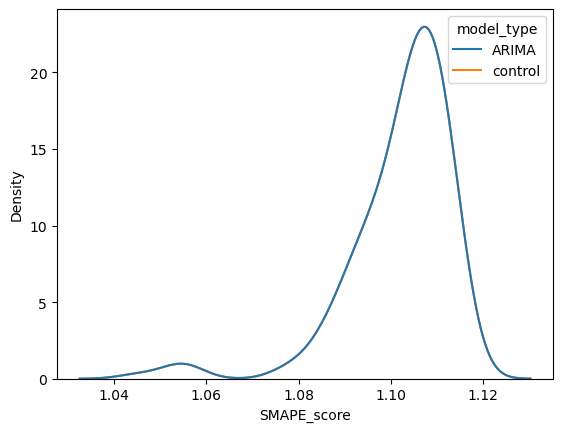

In [9]:
sns.kdeplot(data=sample_smape_scores_df, x='SMAPE_score', hue='model_type')

Well, well, well. It took me a minute to realize what is going on here. The control and ARIMA SMAPE values are pairwise identical for all of the samples. But, look at the 'winning' parameters: lag and moving average order 0, difference degree 1. I'm pretty sure that reduces to a carry forward model. No autoregression and no moving average...

Still not sure why in experiment #1. block size 37, lag and moving average order zero with difference degree 1 seems to do such a better job than the control. My guess is that it was small sample size/number. But, I don't think it's worth running again. Time to move on.